# ResOpsBR: attributes
***

**Autor:** Chus Casado Rodríguez<br>
**Fecha:** 27-11-2024<br>

**Introduction:**<br>
This code compares the available attributes for reservoirs in Brazil from different sources: the Brazilian Ministry and GRanD.

**To be checked:**<br>

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import sys
sys.path.append('../../src/')
import geopandas as gpd
from shapely.geometry import Point
import re

import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('ticks')
import yaml

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.utils import filter_reservoirs

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Configuration

In [2]:
cfg = DatasetConfig('config_dataset.yml')

print(f'Attributes will be saved in {cfg.PATH_ATTRS}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsBR\v1.0\attributes


In [3]:
# with open('config_dataset.yml', 'r', encoding='utf8') as ymlfile:
#     cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# VERSION = cfg['version']

# #paths
# PATH_RESOPS = Path(cfg['paths']['dataset']['root'])
# # PATH_GLOFAS = Path(cfg['paths']['GloFAS']['root'])
# PATH_GRAND = Path(cfg['paths']['GRanD'])

# # conditions to consider a reservoir in the ResOpsES dataset
# MIN_AREA = cfg['conditions'].get('min_area', None) # km2
# MIN_VOL = cfg['conditions'].get('min_volume', None) # hm3

# # path where results will be saved
# PATH_OUT = PATH_RESOPS / VERSION / 'attributes'
# PATH_PLOTS = PATH_OUT / 'plots'
# PATH_PLOTS.mkdir(parents=True, exist_ok=True)
# print(f'Attributes will be saved in {PATH_OUT}')

## ANA

ANA
---
Catalogue
No. reservoirs:	163
No. attributes:	26



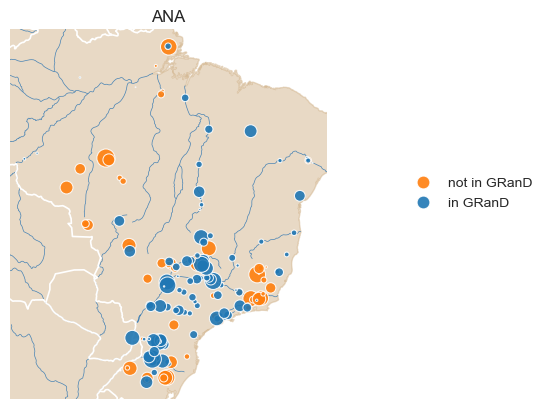

In [4]:
# load ANA reservoirs
ana = gpd.read_file(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'SIN' / 'Sistema_de_Acompanhamento_de_Reservatórios_-_Sistema_Interligado_Nacional.shp')
ana.set_index('SAR_ID', drop=True, inplace=True)
ana.GRAND_ID = ana.GRAND_ID.astype('Int64')

print('ANA')
print('---')
print('Catalogue')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*ana.shape))

mask_grand = ana.GRAND_ID.notnull()
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
ax.add_feature(cfeature.BORDERS, edgecolor='w', lw=1.2, zorder=2)
ax.add_feature(cfeature.RIVERS, edgecolor='steelblue', lw=.5, zorder=1)
ana[~mask_grand].plot(markersize=np.sqrt(ana.SAR_VO_MAX), c='C1', edgecolor='w', lw=.75, alpha=.9, ax=ax, zorder=10, label='not in GRanD')
ana[mask_grand].plot(markersize=np.sqrt(ana.SAR_VO_MAX), c='C0', edgecolor='w', lw=.75, alpha=.9, ax=ax, zorder=10, label='in GRanD')
ax.set_title('ANA')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

## GRanD 

GRanD
-----
No. reservoirs:	204
No. attributes:	61

180 out of 204 reservoirs exceed the minimum catchment area of 250 km2 (0 missing values)
203 out of 204 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
180 out of 204 reservoirs exceed the minimum catchment area (250 km2) and the minimum reservoir volume (10 hm3)


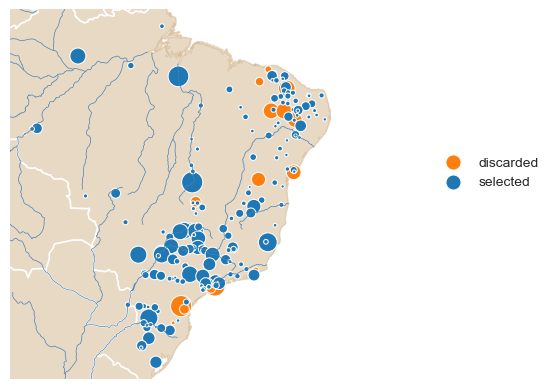

In [8]:
# load shapefile of dams
grand = gpd.read_file(cfg.PATH_GRAND / 'GRanD_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=False, inplace=True)

# filter dams in Spain
grand = grand.loc[grand.COUNTRY == 'Brazil']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()
grand.RES_NAME = grand.RES_NAME.str.upper()
grand.ADMIN_UNIT = grand.ADMIN_UNIT.str.upper()

# rename columns
grand['LON'] = grand.geometry.x
grand['LAT'] = grand.geometry.y

print('GRanD')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

# select reservoirs based on catchment area and reservoir volume
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, cfg.MIN_AREA, cfg.MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
ax.add_feature(cfeature.BORDERS, edgecolor='w', lw=1.2, zorder=1)
ax.add_feature(cfeature.RIVERS, edgecolor='steelblue', lw=.5, zorder=2)
grand.loc[~mask_grand].plot(markersize=np.sqrt(grand.CAP_MCM), c='C1', edgecolor='w', lw=.75, ax=ax, label='discarded')
grand.loc[mask_grand].plot(markersize=np.sqrt(grand.CAP_MCM), c='C0', edgecolor='w', lw=.75, ax=ax, label='selected')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# grand = grand.loc[mask_grand]

### Connect ANA and GRanD

I've done the connection manually in GIS.

In [9]:
# keep ANA reservoirs with GRanD ID
ana = ana[ana.GRAND_ID.notnull()]
ana.reset_index(inplace=True)
ana.set_index('GRAND_ID', drop=True, inplace=True)

In [10]:
# keep GRanD reservoirs in SIN
grand = grand.loc[ana.index]

### Reservoir use

In [11]:
# rename columns
rename_uses_grand = {'USE_IRRI': 'irrigation',
                     'USE_ELEC': 'hydropower',
                     'USE_SUPP': 'supply',
                     'USE_FCON': 'flood',
                     'USE_RECR': 'recreation',
                     'USE_NAVI': 'navigation',
                     'USE_FISH': 'fish',
                     'USE_PCON': 'pollution',
                     'USE_LIVE': 'livestock',
                     'USE_OTHR': 'other'}
grand.rename(columns=rename_uses_grand, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
grand.MAIN_USE.replace({'Irrigation': 'irrigation',
                        'Hydroelectricity': 'hydropower',
                        'Water supply': 'supply',
                        'Other': 'other',
                        'Recreation': 'recreation',
                        'Flood control': 'flood'},
                       inplace=True)

# convert to boolean
grand_uses = list(rename_uses_grand.values())
grand[grand_uses] = grand[grand_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
grand['SINGLE_USE'] = False
mask_singleuse = grand[grand_uses].sum(axis=1) == 1
grand.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [12]:
mask_singleuse = grand.SINGLE_USE
mask_hdcc = ~grand.index.isnull()

mainuse_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = grand.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_grand = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_grand.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [13]:
alluses_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, grand_uses].sum()
alluses_multipurpose = grand.loc[mask_hdcc, grand_uses].sum()
alluses_summary_grand = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_grand.columns = ['singlepurpose', 'multipurpose']
alluses_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_grand.dropna(axis=0, how='all', inplace=True)
alluses_summary_grand = alluses_summary_grand[~(alluses_summary_grand == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

In [16]:
### Export

# convert boolean fields to 0-1
bool_cols = list(rename_uses_grand.values()) + ['SINGLE_USE']
grand[bool_cols] = grand[bool_cols].astype(bool).astype(int)

# attributes to be included from GRanD
cols_grand = ['RES_NAME', 'DAM_NAME', 'YEAR', 'REM_YEAR', 'LON', 'LAT',
              'DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
              'irrigation', 'hydropower', 'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution', 'livestock', 'other', 'MAIN_USE', 'SINGLE_USE','LAKE_CTRL']

# export as CSV
grand[cols_grand].to_csv(cfg.PATH_ATTRS / 'grand.csv')
#grand.loc[:, cols_grand].to_csv(PATH_OUT / 'attributes_GRanD.csv')

# export SIN attributes
ana.drop('geometry', axis=1).sort_index().to_csv(cfg.PATH_ATTRS / 'ana.csv')

***

#### `lfcoords`

In [41]:
mask = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, MIN_AREA, MIN_VOL)

100 out of 100 reservoirs exceed the minimum catchment area of 250 km2 (0 missing values)
100 out of 100 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
100 out of 100 reservoirs exceed the minimum catchment area (250 km2) and the minimum reservoir volume (10 hm3)


In [42]:
grand.columns

Index(['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER',
       'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY', 'ADMIN_UNIT',
       'SEC_ADMIN', 'COUNTRY', 'SEC_CNTRY', 'YEAR', 'ALT_YEAR', 'REM_YEAR',
       'DAM_HGT_M', 'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM',
       'AREA_POLY', 'AREA_REP', 'AREA_MAX', 'AREA_MIN', 'CAP_MCM', 'CAP_MAX',
       'CAP_REP', 'CAP_MIN', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL',
       'CATCH_SKM', 'CATCH_REP', 'DATA_INFO', 'irrigation', 'hydropower',
       'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution',
       'livestock', 'other', 'MAIN_USE', 'LAKE_CTRL', 'MULTI_DAMS', 'TIMELINE',
       'COMMENTS', 'URL', 'QUALITY', 'EDITOR', 'LONG_DD', 'LAT_DD', 'POLY_SRC',
       'geometry', 'LON', 'LAT', 'SINGLE_USE'],
      dtype='object')

In [51]:
lfcoords = grand[['LAT', 'LON', 'CATCH_SKM']].copy()
lfcoords.index.name = 'ID'
lfcoords.columns = ['lat', 'lon', 'area']
lfcoords.sort_index(inplace=True)
path_lfcoords = PATH_RESOPS / 'ancillary' / 'lfcoords'
path_lfcoords.mkdir(parents=True, exist_ok=True)
lfcoords.to_csv(path_lfcoords / 'dams.csv')

***

#### `cutmaps`

In [72]:
path_cutmaps = PATH_RESOPS / 'ancillary' / 'cutmaps'
path_cutmaps.mkdir(parents=True, exist_ok=True)

points = gpd.read_file(path_lfcoords / 'lfcoords.shp')
points['lon'] = points.geometry.x
points['lat'] = points.geometry.y
points.rename(columns={'ID': 'id'}, errors='ignore', inplace=True)
points[['lon', 'lat', 'id']].to_csv(
    path_cutmaps / 'reservoirs.txt',
    sep='\t',
    header=False,
    index=False,
    float_format='%.4f'
)

***

#### `ncextract`

In [74]:
path_ncextract = PATH_RESOPS / 'ancillary' / 'ncextract'
path_ncextract.mkdir(parents=True, exist_ok=True)

points[['id', 'lat', 'lon']].to_csv(
    path_ncextract / 'reservoirs.csv',
    header=True,
    index=False,
    float_format='%.4f'
)

***